In [1]:
import numpy as np
from scipy import stats
import statsmodels.stats.multitest

## Gather Correlation Data

In [2]:
models = ['linear', 'linear_sgd']
subjects = ['F', 'H', 'I', 'J', 'K', 'L', 'M', 'N']
rois = ['PostTemp', 'AntTemp', 'AngularG', 'IFG', 'MFG', 'IFGorb', 'pCingulate', 'dmpfc', 'NonROI']
layer = 1
context_length = 1
reg_prefix = 'reg'
preds_path = 'encoder_preds/maxvoxels/predict_{}_with_bert_layer_{}_len_{}_encoder_{}_{}.npy'

roi_masks = np.load('../HP_subj_roi_inds.npy', allow_pickle=True)
mean_stats = {}

In [3]:
for model in models:
    print("Model: {}".format(model))
    mean_stats[model] = {}
    for roi in rois:
        print("ROI: {}".format(roi))
        mean_stats[model][roi] = []
        for sub in subjects:
            curr_path = preds_path.format(sub, layer, context_length, model, reg_prefix)
            corrs = np.nanmean(np.load(curr_path, allow_pickle=True).item()['corrs_t'], 0) # Average across four folds
            if roi == 'NonROI':
                roi_mask = ~(roi_masks.item()[sub]['all'])
            else:
                roi_mask = roi_masks.item()[sub][roi]
            roi_corrs = corrs[roi_mask]
            mean_stats[model][roi].append(np.nanmean(roi_corrs))

Model: linear
ROI: PostTemp
ROI: AntTemp
ROI: AngularG
ROI: IFG
ROI: MFG
ROI: IFGorb
ROI: pCingulate
ROI: dmpfc
ROI: NonROI
Model: linear_sgd
ROI: PostTemp
ROI: AntTemp
ROI: AngularG
ROI: IFG
ROI: MFG
ROI: IFGorb
ROI: pCingulate
ROI: dmpfc
ROI: NonROI


In [27]:
# Print Mean Correlations
for roi in rois:
    print('{} Corrs:'.format(roi))
#     for model in models:
#         print('{}: MeanCorr={}'.format(model, mean_stats[model][roi]))
#     mean_corr_diffs = np.subtract(mean_stats['linear'][roi], mean_stats['linear_sgd'][roi])
#     mean_diff, stderr_diff = mean_corr_diffs.mean(), np.std(mean_corr_diffs)/np.sqrt(len(mean_corr_diffs))
#     print('Mean={}, StdErr={} ,T={}'.format(mean_diff, stderr_diff, mean_diff/stderr_diff))
#     print('MeanDiffs={}; SumDiffs={}'.format(np.absolute(mean_corr_diffs).mean(), np.absolute(mean_corr_diffs).sum()))
    mean_lin_corr = np.array(mean_stats['linear'][roi]).mean()
    mean_sgd_corr = np.array(mean_stats['linear_sgd'][roi]).mean()
    stddev_lin_corr = np.std(np.array(mean_stats['linear'][roi]))
    stddev_sgd_corr = np.std(np.array(mean_stats['linear_sgd'][roi]))
    print("LinAna={}\nLinSGD={}".format(mean_stats['linear'][roi], mean_stats['linear_sgd'][roi]))
    print("Mean: LinAna={}; LinSGD={}".format(mean_lin_corr, mean_sgd_corr))
    print("StdDev: LinAna={}; LinSGD={}".format(stddev_lin_corr, stddev_sgd_corr))
    print('\n')

PostTemp Corrs:
LinAna=[0.08673937664875223, 0.1528259169389459, 0.13409155609596254, 0.10804870381071434, 0.10628028738640972, 0.07766399771562231, 0.1243714947854326, 0.05872645417384763]
LinSGD=[0.08063391709887857, 0.14804859160498568, 0.12557179938053767, 0.08864008780221197, 0.09858713253223025, 0.0673664803214254, 0.12106782706208741, 0.04853707452939961]
Mean: LinAna=0.1060934734444609; LinSGD=0.09730661379146957
StdDev: LinAna=0.029009068547778134; LinSGD=0.030756850970379963


AntTemp Corrs:
LinAna=[0.09654985388486502, 0.10117459944317586, 0.11756701903074816, 0.071466544170615, 0.09048114521203963, 0.10533387833695529, 0.10277906318132295, 0.02423535583656091]
LinSGD=[0.09307499803005208, 0.09772704378712671, 0.11090936000788634, 0.048473293384595315, 0.0832069771622554, 0.0936827012749515, 0.09358179123821851, 0.019309491001833424]
Mean: LinAna=0.08869843238703536; LinSGD=0.07999570698586492
StdDev: LinAna=0.027343420961779313; LinSGD=0.02850401117821317


AngularG Corrs:


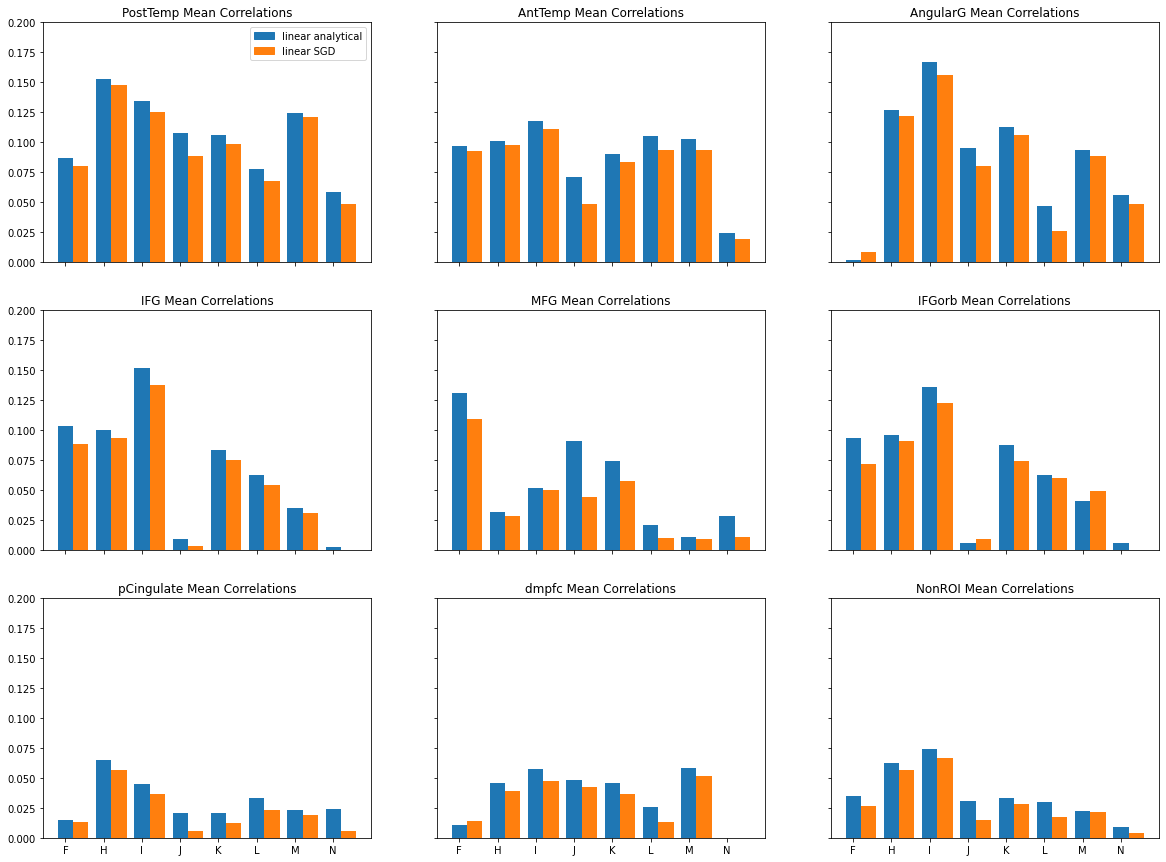

In [39]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,15))
for idx in range(len(rois)):
    roi = rois[idx]
    i = idx//3
    j = idx%3
    axs[i,j].set_title('{} Mean Correlations'.format(roi))
    axs[i,j].bar([a for a in range(len(mean_stats['linear'][roi]))], mean_stats['linear'][roi], align='center', width=0.4)
    axs[i,j].bar([a+0.4 for a in range(len(mean_stats['linear'][roi]))], mean_stats['linear_sgd'][roi], align='center', width=0.4)
    axs[i,j].set_ylim(0.0, 0.2)
    axs[i,j].set_xticks(range(len(subjects)))
    axs[i,j].set_xticklabels(subjects)
    if i == 0 and j == 0:
        colors = {'linear analytical':'tab:blue', 'linear SGD':'tab:orange'}         
        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        axs[i,j].legend(handles, labels)
plt.show()

## Perform paired t-tests

In [ ]:
ts, pvals = [], []
for roi in rois:
    linear_corrs = mean_stats['linear'][roi]
    linear_sgd_corrs = mean_stats['linear_sgd'][roi]
    t, pval = stats.ttest_rel(linear_corrs, linear_sgd_corrs)
    ts.append(t)
    pvals.append(pval)
    print(roi, t, pval)

In [ ]:
one_sided_pvals = [pval/2 for pval in pvals]
print(one_sided_pvals)
adjusted_pvals = statsmodels.stats.multitest.multipletests(one_sided_pvals, alpha=0.05, method='fdr_bh')
adjusted_pvals

In [ ]:
# Print paired t-test results
for roi_idx in range(len(rois)):
    print("{}: \n adjusted p-val={}, reject={}".format(rois[roi_idx], adjusted_pvals[1][roi_idx], adjusted_pvals[0][roi_idx]))

## Rough Work

In [ ]:
# num_nans = {}
# num_totals = {}

In [ ]:
for model in models:
    mean_stats[model] = {}
#     num_nans[model] = {}
#     num_totals[model] = {}
    for sub in subjects:
        mean_stats[model][sub] = {}
#         num_nans[model][sub] = {}
#         num_totals[model][sub] = {}
        curr_path = preds_path.format(sub, layer, context_length, model, reg_prefix)
        corrs = np.nanmean(np.load(curr_path, allow_pickle=True).item()['corrs_t'], 0) # Average across four folds
        for roi in rois:
            roi_mask = roi_masks.item()[sub][roi]
            roi_corrs = corrs[roi_mask]
#             num_nans[model][sub][roi] = np.sum(np.isnan(roi_corrs))
#             num_totals[model][sub][roi] = (roi_corrs).shape[0]
            mean_roi_corrs = np.nanmean(roi_corrs)
            mean_stats[model][sub][roi] = mean_roi_corrs
        nonroi_mask = ~(roi_masks.item()[sub]['all'])
        nonroi_corrs = corrs[nonroi_mask]
        mean_nonroi_corrs = np.nanmean(nonroi_corrs)
        mean_stats[model][sub]['NonROI'] = mean_nonroi_corrs

In [ ]:
for sub in subjects:
    for roi in rois:
        print('{}_{}'.format(sub, roi))
        for model in models:
            print('{}: MeanCorr={} | NumNans/NumTotal={}/{}'.format(model, mean_stats[model][sub][roi], num_nans[model][sub][roi], num_totals[model][sub][roi]))